In [1]:
# default_exp data.load_pd

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *

In [4]:
# hide
from nbdev.showdoc import *

# Data Load Dataframe


> Using the fastai2 `Datasets` to make an time series dataset.

A multivaraite time-series dataloader. 

TODO reduce mem: https://forums.fast.ai/t/how-to-handle-dataframes-too-large-to-fit-in-memory/39208/19

In [5]:
# export
import numpy as np
import pandas as pd

In [6]:
class TSeries(TensorBase):pass

In [7]:
def no_emp_dim(x):
    if len(x.shape)==1 :
        x = x[None,:]
    return np.vstack(x)

def show_graph(array, ax=None, figsize=None, title=None, ctx=None, tx=None, **kwargs):
    "Show an array on `ax`."
    if hasattrs(array, ('data','cpu','permute')):
        array = array.data.cpu()
    elif not isinstance(array,np.ndarray):
        array=array(array)
    arrays = no_emp_dim(array)
    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (5,5)
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    tx = ifnone(tx,np.arange(arrays[0].shape[0]))
    label = kwargs.pop('label', 'x')
    for a, c in zip(arrays, ['b', 'c', 'm', 'y', 'k',]):
        ax.plot(tx, a, '-*'+c,label=label, **kwargs)

    if title is not None: ax.set_title(title)

    ax.legend()
#     ax.axis('off')
    return ax

In [8]:
# export
class TensorSeqs(TSeries):
    
    def show(self, ax = None, ctx=None, **kwargs):
        ctx = ifnone(ctx, ax)
        if ctx is None: _, ctx = plt.subplots(figsize=(5,5))
        array = np.array(self.cpu())
        arrays = no_emp_dim(array)
        m = self._meta.get('m',['b', 'c', 'm', 'y', 'k',][:len(arrays)])
        labels = self._meta.get('label',['x']*len(arrays))
        t = np.arange(array.shape[1])        
        for a, c, label in zip(arrays, m, labels):            
            mark = '-' if 'y' not in label else ''                
            ctx.plot(t, a, mark + '*' +c, **kwargs, label=label)
        ctx.legend()
        return ctx
    

In [9]:
a = torch.cat([i+torch.arange(10)[None,:] for i in [0,2]])

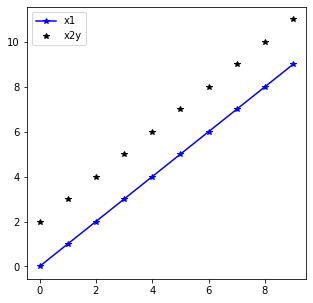

In [10]:
_, ctx = plt.subplots(figsize=[5,5])
ax = TensorSeqs(a, m=['b','k'], label = ['x1','x2y']).show(ctx=ctx)

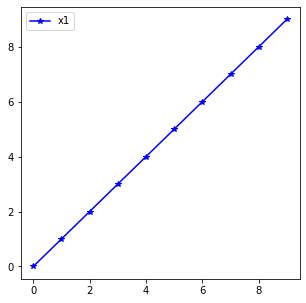

In [11]:
ax = TensorSeqs(torch.arange(10)[None,:], m=['b','k'], label = ['x1','x2']).show()

In [12]:
# export
class TensorCon(TSeries):
    def show(self, ax = None, ctx=None):
        ax = ifnone(ax,ctx)
        if ax is None:
            _, ax = plt.subplots(figsize=(5,5))
        ax.set_title(ax.title._text +f" {self._meta.get('label','con')}: {str(self)}")
        return ax
    
class TensorCat(TSeries):
    def show(self, ax = None, ctx=None):
        ax = ifnone(ax,ctx)
        if ax is None:
            _, ax = plt.subplots(figsize=(5,5))
        ax.set_title(ax.title._text +f" {self._meta.get('label','cat')}: {str(self)}")
        return ax

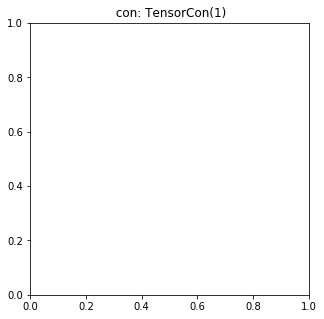

In [13]:
TensorCon(1).show()

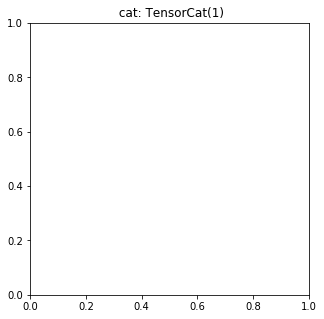

In [244]:
TensorCat(1).show()

In [245]:
# export
class MultiTS(Tuple):pass

## Utils

In [15]:
# export
from typing import List
def same_size_ts(ts:pd.Series, ts_names:List[str]):    
    all_same = [[(ts[c].shape == ts[a].shape) for c in ts_names] for a in ts_names]
    mask = np.array(all_same)    
    return np.sum(mask) == len(ts_names)**2
    

In [16]:
df = pd.DataFrame(data={'ts_0':[pd.Series(np.arange(10)),
                           pd.Series(np.arange(10))],
                   'ts_1':[pd.Series(np.arange(1,11)),
                           pd.Series(np.arange(1,12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})
for i, row in df.iterrows():
    if i == 0:
        test_eq(same_size_ts(row,['ts_0','ts_1']),True)
    if i == 1:
        test_eq(same_size_ts(row,['ts_0','ts_1']),False)

In [17]:
# export
def get_part_of_ts(x, lookback_id, length, pad=np.mean):
    if len(x.shape) == 1:
        x = x[None,:]
    if isinstance(x[0,0],int):
        x = x.astype(float)
    if x.shape[-1] < length:
        # If the time series is too short, we pad
        padding = pad(x, -1)
        x = tensor(np.pad(
            x, # report issue https://github.com/numpy/numpy/issues/15606
            pad_width=((0, 0), (length - x.shape[-1], 0)),
            mode='constant',
            constant_values=padding
        )).float()
        assert x.shape == (x.shape[0],length), f"{x.shape}\t,{lookback_id}, 'tsshape':{x.shape}"
    else:
        x = tensor(x[:,lookback_id:lookback_id + length]).float()
    return x


In [18]:
x = np.arange(10)
test_eq(get_part_of_ts(x, 2, 5), torch.arange(2,7.)[None,:])
x = np.arange(10)[None,:]
test_eq(get_part_of_ts(x, 2, 5), torch.arange(2,7.)[None,:])
test_eq(get_part_of_ts(x, 0, 11), tensor([[4., 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))
x = np.vstack([np.arange(10)]*2)
test_eq(get_part_of_ts(x, 2, 5), torch.cat([torch.arange(2,7.)[None,:]]*2))
test_eq(get_part_of_ts(x, 0, 11), tensor([[4., 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                          [4, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

# report issue https://github.com/numpy/numpy/issues/15606
x = np.arange(10)[None,:]
# test_eq(get_part_of_ts(x, 0, 11), tensor([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

# Dataloader

In [179]:
# export
@delegates()
class DfDataLoader(TfmdDL):
    def __init__(self, dataset:pd.DataFrame, y_name:str, horizon:int, lookback=72, step=1, min_seq_len=None, max_std= None, norm=True, **kwargs):
        store_attr(self,'horizon,lookback,step,max_std,norm,y_name')
        self.min_seq_len = ifnone(min_seq_len, lookback)
        self.dataset = dataset
        self.con_names, self.cat_names, self.ts_names = L(), L(), L()
        for col in dataset.columns:
            t = type(dataset[col].iloc[0])
            if t is pd.core.series.Series:
                self.ts_names.append(col)
            elif t is np.ndarray:
                self.dataset[col] = pd.Series([pd.Series(o.flatten()) for o in self.dataset[col]])
                self.ts_names.append(col)
            elif isinstance(dataset[col].iloc[0], int) or t is np.int64:
                self.con_names.append(col)
            elif isinstance(dataset[col].iloc[0], float):
                self.cat_names.append(col)
            else:
                raise Exception(t) 
        assert y_name in self.ts_names
        self.ts_names.remove(y_name)
        n = self.make_ids()
        super().__init__(dataset=self.dataset, **kwargs)
        self.n = n
        self.skipped= []      

    @delegates(TfmdDL.new)
    def new(self, dataset=None, cls=None, **kwargs):
        for k,v in {k:getattr(self,k) for k in ['horizon', 'lookback', 'step']}.items():
            if k not in kwargs:
                kwargs[k] = v
        res = super().new(dataset = dataset,cls= cls, y_name= self.y_name, **kwargs)
        res.make_ids()
        return res
    
    def check_std(self, r):  
        if self.max_std is not None:
            if (r[-1]/(r[0].std()+1e-7)).std() > self.max_std:
                if idx not in self.skipped:
                    self.skipped.append(idx)
                raise SkipItemException()
        
    def make_ids(self):
        """Make ids if the sequence is shorter than `min_seq_len`, it will drop that sequence."""
        # Slice each time series into examples, assigning IDs to each
        last_id = 0
        n_dropped = 0
        n_needs_padding = 0
        self._ids = {}
        for i, ts in self.dataset.iterrows(): 
            assert same_size_ts(ts, self.ts_names), f"row {i} are not all the time series the same length"
            num_examples = (ts[self.y_name].shape[-1] - self.lookback - self.horizon + self.step) // self.step
            # Time series shorter than the forecast horizon need to be dropped.
            if ts[self.y_name].shape[-1] < self.min_seq_len:
                n_dropped += 1
                continue
            # For short time series zero pad the input
            if ts[self.y_name].shape[-1] < self.lookback + self.horizon:
                n_needs_padding += 1
                num_examples = 1
            for j in range(num_examples):
                self._ids[last_id + j] = (i, j * self.step)
            last_id += num_examples

        # Inform user about time series that were too short
        if n_dropped > 0:
            print("Dropped {}/{} time series due to length.".format(
                    n_dropped, len(self.dataset)))

        # Inform user about time series that were short
        if n_needs_padding > 0:
            print("Need to pad {}/{} time series due to length.".format(
                    n_needs_padding, len(self.dataset)))
        # Store the number of training examples
        return int(self._ids.__len__() )
    
        def shuffle_fn(self, idxs):
#         self.dataset.shuffle()        
            return idxs

    def get_id(self, idx):
        ts_id, lookback_id = self._ids[idx]
        row = self.dataset.iloc[ts_id, :]
        x = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback)        
        y = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback + self.horizon)
        tsx = np.concatenate([o[None,:] for o in row[self.ts_names].to_numpy()])
        tsx = get_part_of_ts(tsx, lookback_id, self.lookback + self.horizon)
        r = [TensorSeqs(x, label=[self.y_name + '_x'], m=['g']), 
             TensorSeqs(tsx, label=self.ts_names)]
        if len(self.cat_names):
            r.append(TensorCon(row[self.cat_names].to_numpy().astype(float),label=self.cat_names))
        if len(self.con_names):
            # TODO make cat its own type
            r.append(TensorCon(row[self.con_names].to_numpy().astype(float),label=self.con_names))            
        # TODO make y its own type
        r.append(TensorSeqs(y, label=[self.y_name+ '_y'], m=['g']))
        return tuple(r)

    def create_item(self, idx):
        if idx>=self.n:
            raise IndexError
        r  = self.get_id(idx)
        self.check_std(r)              
        return MultiTS(r[:-1]),r[-1]
    

The data will be stored in pandas DataFrames. This can be use for time series by nesting series into a cell. An example is shown below: 

In [180]:
df = pd.DataFrame(data={'pred':[np.arange(10.),
                           np.arange(12.)],
                   'ts_0':[np.ones(10)[None,:],
                           np.ones(12)[None,:]],
                   'ts_1':[pd.Series(np.arange(1,11)+np.random.randn(10)),
                           pd.Series(np.arange(1,13)+np.random.randn(12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})
df

,pred,ts_0,ts_1,var_0,con_0
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 0.668125 1 1.974872 2 3.291853 3 4.155591 4 6.443194 5 7.113063 6 6.184216 7 6.572185 8 8.599825 9 8.926087 dtype: float64,0.0,0
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 0.165612 1 2.441811 2 3.821304 3 4.685412 4 5.732396 5 7.103337 6 5.262820 7 8.308854 8 9.503755 9 10.453626 10 11.079857 11 10.555611 dtype: float64,1.0,1


In [181]:
horizon,lookback = 2,9
dl = DfDataLoader(df, 'pred', horizon = horizon, lookback = lookback)


Need to pad 1/2 time series due to length.


In [185]:
for o in dl:
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'],o[0])}
    print({k:v.shape for k,v in dct.items()})
    test_eq(dct['x'].shape,(3,1,9))
    test_eq(type(o), tuple)
    print([type(v) for k,v in dct.items()])
    break
dl.ts_names

{'x': torch.Size([3, 1, 9]), 'tsx': torch.Size([3, 1, 11])}
[<class '__main__.TensorSeqs'>, <class '__main__.TensorSeqs'>]


(#1) ['ts_0']

In [192]:
# hide
# without cat or con
horizon,lookback = 2,9
dl = DfDataLoader(df[['pred','ts_0']], 'pred', horizon = horizon, lookback = lookback)


for o in dl:
    dct = {k:v for k,v in zip(['pred','ts_0'],o[0])}
    print({k:(v.shape,type(v)) for k,v in dct.items()})
    test_eq(dct['ts_0'].shape, o[-1].shape)
    test_eq(dct['pred'].shape[1:],(1,9))
    break


Need to pad 1/2 time series due to length.
{'pred': (torch.Size([3, 1, 9]), <class '__main__.TensorSeqs'>), 'ts_0': (torch.Size([3, 1, 11]), <class '__main__.TensorSeqs'>)}


In [193]:
# hide
# test self.new
dl.new()

Need to pad 1/2 time series due to length.
Need to pad 1/2 time series due to length.


# Showing

In [248]:
# export

from fastai2.vision.data import get_grid

@typedispatch
def show_batch(x:MultiTS, y:TensorSeqs, samples, ctxs=None, max_n=10,rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), rows=rows, cols=cols, add_vert=1, figsize=figsize)
    for i,(ctx, sample) in enumerate(zip(ctxs, samples)):
        for o, _type, label, m in zip(sample[0], [TensorSeqs, TensorSeqs, TensorCon, TensorCat], ['x','xts', 'con','cat'],['g','b',None,None]):   
            ctx = _type(o, label =label, m =m ).show(ctx=ctx)
        ctx = TensorSeqs(y[i],label='y', m='g').show(ctx = ctx)
    return ctxs


# Intergration Example

In [249]:
from fastseq.data.external import *

In [250]:
horizon,lookback = 5,10
df = dummy_data_generator_multi(32)
df.head()

,x,weather,city,cont
0,"[[-0.8024669792693879, -0.8789204584461828, -1.1298152429390844, -0.838628338580094, 0.14368431400644696, -0.23326871405554112, -0.40596991851105296, -0.2035114791824274, 0.17910751690866467, 0.29472294706823676, -0.21460001024673686, -1.2763653462515334, -1.7415549666480419, -1.2759680439163588, -0.32844149997058725, 0.05805962763259887, 1.584574269409853, 1.898472449888363, 2.0853642670163093, 2.1577751464554593, 1.98324193319995, 0.9761877291687643, -0.27634921894356484, -0.7111854244799178, -0.6203103181951914, -0.026621142648322348, 0.10260786066020337, -0.37120927614428073, -0.711319...","[[5.056660134883732, 3.9536588420150833, 3.1583002673912204, 3.518706568163369, 3.720198292669317, 2.3452762648156877, 0.2683893006953184, -0.18473851952156028, 1.6316410113901456, 3.55462258640143, 3.2140057732603537, 1.0252588229406865, -0.38641277943007446, 0.44552012316640377, 2.1248468459277228, 2.4666962375111603, 5.056660134883732, 3.9536588420150833, 3.1583002673912204, 3.518706568163369, 3.720198292669317, 2.3452762648156877, 0.2683893006953184, -0.18473851952156028, 1.6316410113901456, 3.55462258640143, 3.2140057732603537, 1.0252588229406865, -0.38641277943007446, 0.4455201231664...",0,0.575178
1,"[[0.6584180321179238, 0.5985199424353711, 0.9341134661820457, 1.4858938262116717, 1.6048347939503669, 1.514506787859161, 1.2142103144856773, 1.2742334144403644, 0.9771003442210596, 1.0088357770124436, 1.0040262747763162, 1.0044641395483405, 0.421120828286073, 0.04661922040235773, -0.49746483705133754, -0.9583028253501954, -0.6870994653083689, -0.6280466097907583, -0.2758925409632559, -0.08159271442133446, 0.05909756715258412, -0.16269683250029268, -0.2564412494944712, -0.7086699255319898, -0.9491945992755426, -0.8104330111738214, -0.8042715830506564, -0.6570377598020841, -1.003602469400799...","[[-0.15408773622635175, 0.45211777588578483, 2.0115603170813823, 3.422092614397859, 3.680107079070976, 2.5446618752312578, 0.6969214781775466, -0.7105962794467429, -0.8166859605485297, 0.37865243487218014, 2.014213469722249, 2.93747931135841, 2.4672854844816925, 0.8445738249616601, -0.9270480784375406, -1.7454329527532642, -0.15408773622635175, 0.45211777588578483, 2.0115603170813823, 3.422092614397859, 3.680107079070976, 2.5446618752312578, 0.6969214781775466, -0.7105962794467429, -0.8166859605485297, 0.37865243487218014, 2.014213469722249, 2.93747931135841, 2.4672854844816925, 0.84457382...",0,1.565212
2,"[[-0.4540391522330465, -0.6986502905060152, -0.33978334637203794, -1.0980574837245591, -1.4961565787697446, -2.0754612646513118, -1.993056938343663, -1.0312848841820426, -0.3211491970228363, 0.2557774959740496, -0.08633379164269124, -0.5158150244998599, -0.5217203657671015, -0.178152555188975, -0.5932236484962977, -0.6580934420114888, -0.8638031206446888, -0.37229942700452, 0.24563620165476477, 0.8213461843632616, 0.8934223894034833, 0.6981786139320755, 0.3104917034349309, 1.1067722496004493, 1.305263256688293, 0.8084786925488624, 0.26947558029513013, 0.3274516135895125, 1.1764740430520735...","[[4.5801333624720595, 4.676394098753349, 5.659302069422344, 6.11512167338171, 4.908011793555525, 3.101735974399693, 2.906779862689573, 4.831844743713669, 6.83973324508663, 6.767540059779465, 4.928010335150714, 3.5536351170557317, 3.9335830599397044, 5.053120600271459, 5.337198718662452, 4.862804022018512, 4.5801333624720595, 4.676394098753349, 5.659302069422344, 6.11512167338171, 4.908011793555525, 3.101735974399693, 2.906779862689573, 4.831844743713669, 6.83973324508663, 6.767540059779465, 4.928010335150714, 3.5536351170557317, 3.9335830599397044, 5.053120600271459, 5.337198718662452, 4.8...",0,-0.149407
3,"[[0.4705903199020001, 0.2678942547271723, 0.3062781654803187, 0.7040626223738288, 1.1238685220516318, 1.3028633374640015, 1.5706129546771224, 1.7622996496096006, 1.9369455148456476, 1.930481301723255, 1.1528044741189476, 0.2416387817094305, -0.1997793717665788, -0.33354828532860087, -0.10122662929761075, -0.283137399974408

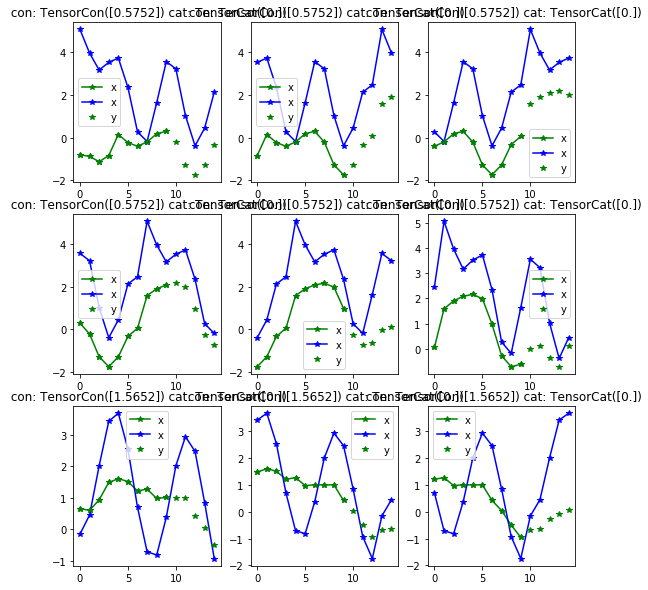

In [252]:
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, step=3)
dl.show_batch(max_n=9)

In [246]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 020_data.load_pd.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 03_data.core_pd.ipynb.
Converted 050_nbeats.models_multi.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
